In [3]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation
import jax

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

from HOSim import solver
f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6))

eta_hat, phi_hat, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None, None

with h5py.File("Z:\\files\\simulation_1d_compressed.h5", "r") as data:
    eta_hat = data["eta_hat"][:]
    phi_hat = data["phi_hat"][:]
    Hs = data["Hs"][:]
    Tp = data["Tp"][:]
    time = data["time"][:]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

In [4]:
from HOSim import solver

Ta = 0.00001 #50

f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6)) #f(t, y, modes, g, k0, mHOS, Ta):
f_partial = lambda t, y: f_jit(t, y, modes, 9.81, 2*np.pi/length, 8, Ta)
f_nested_vec = jax.jit(jax.vmap(jax.vmap(f_partial, in_axes=(None, 0)), in_axes=(None, 0)))

step_size = 0.025

y = np.concatenate((eta_hat[:, 1801:201:-50, :], phi_hat[:, 1801:201:-50, :]), axis=-1)
y_next = np.concatenate((eta_hat[:, 200:1800:50, :], phi_hat[:, 200:1800:50, :]), axis=-1)
g = 9.81
f = f_nested_vec(0.025, y)
f_next = f_nested_vec(0.025, y_next)

k0 = 2*np.pi/length
K = np.diag(np.arange(0, modes+1)*k0)
G = np.diag(np.ones(modes+1)*(-g))
A = np.block([[np.zeros_like(K), K], [G, np.zeros_like(G)]])

B = (y - y_next).reshape(-1, A.shape[1]) 
result = B @ A.T 
K_lin = result.reshape(y.shape) 
K_lin_eta = K_lin[:, :, :modes+1]
K_lin_phi = K_lin[:, :, modes+1:]

K_eta_nonlin = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1] - K_lin_eta)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
K_phi_nonlin = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:] - K_lin_phi)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))

K_eta_total = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
K_phi_total = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))

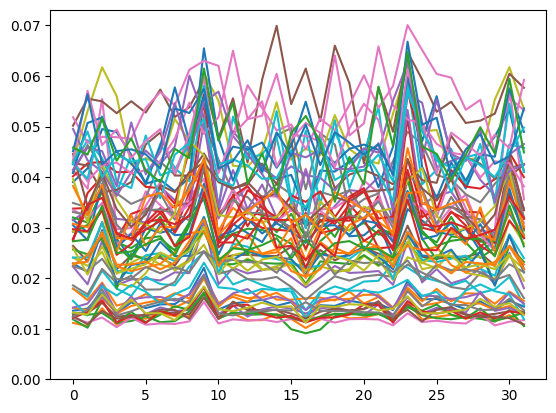

(0.0, 0.17407414515917438)

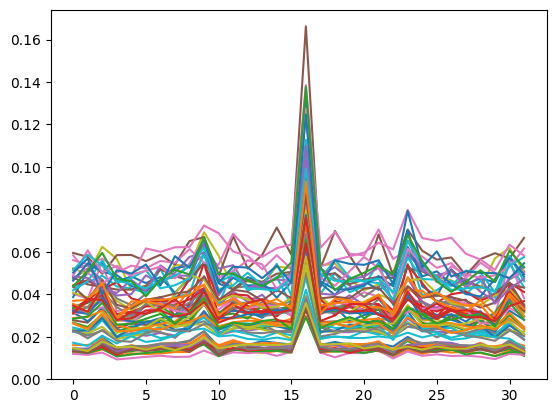

In [ ]:
for i in range(64):
    plt.plot(K_eta_nonlin[i, :])
    # plt.plot(K_phi_nonlin[i, :])
plt.ylim(0)
plt.show()

for i in range(64):
    plt.plot(K_phi_nonlin[i, :])
plt.ylim(0)
    

c:\Users\Vegard\miniconda3\envs\ML\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Vegard\miniconda3\envs\ML\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(500.0, 700.0)

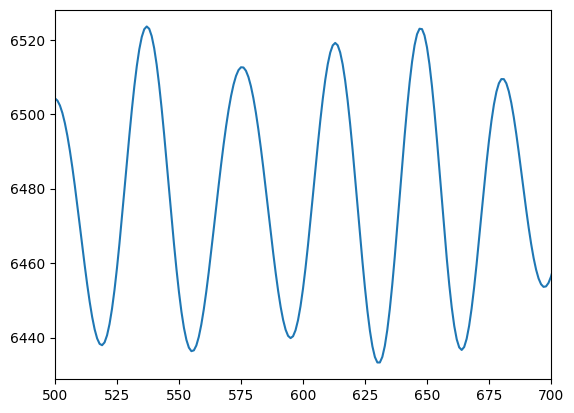

In [50]:
k = np.arange(0, modes+1)*2*np.pi/3000

# plt.plot(np.sum(eta_hat[0]*eta_hat[0].conj(), axis=-1))

plt.plot(np.sqrt(np.sum(phi_hat[0]*phi_hat[0].conj(), axis=-1)))
plt.xlim(500, 700)

In [ ]:
f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6)) #f(t, y, modes, g, k0, mHOS, Ta):
f_partial = lambda t, y: f_jit(t, y, modes, 9.81, 2*np.pi/length, 8, 50)
f_nested_vec = jax.jit(jax.vmap(jax.vmap(f_partial, in_axes=(None, 0)), in_axes=(None, 0)))

rk4_jit = jax.jit(solver.rk4_step, static_argnums=(0, 2, 3, 4, 5, 6, 7, 8)) #rk4_step(t, y, h, modes, g, k0, mHOS, Ta, f_jit):
rk4_partial = lambda t, y: solver.rk4(t, y, 0.025, modes, 9.81, 2*np.pi/length, 8, 50, f_jit)
rk4_nested_vec = jax.jit(jax.vmap(jax.vmap(rk4_partial, in_axes=(None, 0)), in_axes=(None, 0)))
K_eta_avg = []
K_phi_avg = []

steps = 200
step_size = 0.025

K_eta_total = np.zeros((*y.shape[:2], steps//20))
K_phi_total = np.zeros((*y.shape[:2], steps//20))

K_eta_nonlin = np.zeros((*y.shape[:2], steps//20))
K_phi_nonlin = np.zeros((*y.shape[:2], steps//20))

f = f_nested_vec(0, y)
for i, t in enumerate(np.arange(0, steps)*step_size):
    y_next = rk4_nested_vec(t, y) #t
    f_next = f_nested_vec(t+step_size, y) #t + step_size

    B = (y - y_next).reshape(-1, A.shape[1]) 
    result = B @ A.T 
    K_lin = result.reshape(y.shape) 
    K_lin_eta = K_lin[:, :, :modes+1]
    K_lin_phi = K_lin[:, :, modes+1:]

    if (i+1) % 20 == 0:
        K_eta_nonlin[:, :, (i+1)//20-1] = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1] - K_lin_eta)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
        K_phi_nonlin[:, :, (i+1)//20-1] = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:] - K_lin_phi)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))

        K_eta_total[:, :, (i+1)//20-1] = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
        K_phi_total[:, :, (i+1)//20-1] = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))
    
    y = y_next
    f = f_next

In [ ]:
from HOSim import solver

gamma = 3.5
g = 9.81
length = 12000*2
modes = 2048*2

mHOS = 8

Hs_list = np.linspace(0.5, 8, 16)
Tp_list = np.linspace(8, 15, 15)

y = np.zeros((len(Tp_list), len(Hs_list), 2*(modes+1)), dtype=complex)
for i, Tp in enumerate(Tp_list):
    for j, Hs in enumerate(Hs_list):
        gamma = 1+7*np.random.random()
        k0 = 2 * np.pi / length
        T1 = 0.834 * Tp
        k = np.arange(1, modes+1)*k0
        w = np.sqrt(k * g)

        sigma = 0.07 * (w <= 5.24/T1) + 0.09 * (w > 5.24/T1)
        Sw = (155 * Hs**2 / T1**4 / w**5 *
            np.exp(-944 / (T1*w)**4) *
            gamma ** np.exp(-((0.191*w*T1 - 1)/(np.sqrt(2)*sigma))**2))
        Sk = Sw * g / (2 * np.sqrt(k * g))

        phases = np.exp(np.random.rand(modes)*2*np.pi*1.j)
        eta_hat_ = np.sqrt(Sk * k0 * 0.5) * phases * 2 * modes
        phi_hat_ = eta_hat_ * np.exp(-1.j * np.pi / 2) * np.sqrt(g / k)

        alias_mask = np.arange(modes+1) < modes * 2 / (mHOS + 1)

        eta_hat_ = np.insert(eta_hat_, 0, 0) * alias_mask
        phi_hat_ = np.insert(phi_hat_, 0, 0) * alias_mask

        y[i, j] = np.concatenate((eta_hat_, phi_hat_))

Ta = 0.00001 #50

f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6)) #f(t, y, modes, g, k0, mHOS, Ta):
f_partial = lambda t, y: f_jit(t, y, modes, 9.81, 2*np.pi/length, 8, Ta)
f_nested_vec = jax.jit(jax.vmap(jax.vmap(f_partial, in_axes=(None, 0)), in_axes=(None, 0)))

rk4_jit = jax.jit(solver.rk4_step, static_argnums=(0, 2, 3, 4, 5, 6, 7, 8)) #rk4_step(t, y, h, modes, g, k0, mHOS, Ta, f_jit):
rk4_partial = lambda t, y: solver.rk4_step(t, y, 0.025, modes, 9.81, 2*np.pi/length, 8, Ta, f_jit)
rk4_nested_vec = jax.jit(jax.vmap(jax.vmap(rk4_partial, in_axes=(None, 0)), in_axes=(None, 0)))

K_eta_avg = []
K_phi_avg = []

step_size = 0.025
g = 9.81

K_eta_total = np.zeros(y.shape[:2])
K_phi_total = np.zeros(y.shape[:2])

K_eta_nonlin = np.zeros(y.shape[:2])
K_phi_nonlin = np.zeros(y.shape[:2])

k0 = 2*np.pi/length
K = np.diag(np.arange(0, modes+1)*k0)
G = np.diag(np.ones(modes+1)*(-g))
A = np.block([[np.zeros_like(K), K], [G, np.zeros_like(G)]])

f = f_nested_vec(0, y)
for i, t in enumerate(np.arange(0, 2)*step_size):
    y_next = rk4_nested_vec(t, y)
    f_next = f_nested_vec(t+step_size, y_next) #t + step_size

    B = (y - y_next).reshape(-1, A.shape[1]) 
    result = B @ A.T 
    K_lin = result.reshape(y.shape) 
    K_lin_eta = K_lin[:, :, :modes+1]
    K_lin_phi = K_lin[:, :, modes+1:]

    K_eta_nonlin[:, :] = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1] - K_lin_eta)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
    K_phi_nonlin[:, :] = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:] - K_lin_phi)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))

    K_eta_total[:, :] = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
    K_phi_total[:, :] = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))

    y = y_next
    f = f_next

In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import curve_fit

TP, HS = np.meshgrid(Tp_list, Hs_list, indexing="ij")
Y = K_eta_nonlin

x_flat = TP.ravel()
y_flat = HS.ravel()
z_flat = Y.ravel()

# ── define candidate 2D models ──
def model_additive_inverse(XY, a, b, c, d, e):
    x, y = XY
    return a + b/(x + c) + d/(y + e)

def model_coupled_inverse(XY, a, b, c, d):
    x, y = XY
    return a + b/(x + c + d*y)

def model_multiplicative_inverse(XY, a, b, c, d, e):
    x, y = XY
    return a + b/((x + c)*(y + d)) + e

models = {
    # "Additive Inverse": (model_additive_inverse,    [1, 1, 0.1, 1, 0.1]),
    # "Coupled Inverse":   (model_coupled_inverse,     [1, 1, 0.1, 0.1]),
    # "Multiplicative":    (model_multiplicative_inverse, [1, 1, 0.1, 0.1, 0]),
}

# ── prepare grid for smooth plotting ──
x_range = np.linspace(x_flat.min(), x_flat.max(), 60)
y_range = np.linspace(y_flat.min(), y_flat.max(), 60)
Xg, Yg   = np.meshgrid(x_range, y_range)

# ── fit each model and compute its surface ──
fit_surfaces = {}
fit_params   = {}
for name, (fn, p0) in models.items():
    popt, _ = curve_fit(fn, (x_flat, y_flat), z_flat, p0=p0, maxfev=10000)
    Zg = fn((Xg, Yg), *popt)
    fit_surfaces[name] = Zg
    fit_params[name] = popt

# ── build the Plotly figure ──
fig = go.Figure()

# original data
fig.add_trace(go.Scatter3d(
    x=x_flat, y=y_flat, z=z_flat,
    mode='markers',
    marker=dict(size=4, color=z_flat, colorscale='Viridis', colorbar=dict(title='K_eta_avg')),
    name='Data'
))

# fitted surfaces
for name, Zg in fit_surfaces.items():
    fig.add_trace(go.Surface(
        x=x_range, y=y_range, z=Zg,
        opacity=0.5,
        name=name
    ))

fig.update_layout(
    title='K_eta_avg Surface Fits',
    scene=dict(
        xaxis_title='Tp [s]',
        yaxis_title='Hs [m]',
        zaxis_title='K_eta_avg'
    ),
    width=900, height=700
)

fig.show()

# ── print out the fitted parameters ──
print("Fitted parameters:")
for name, p in fit_params.items():
    print(f"  {name}: {np.round(p, 4)}")


Fitted parameters:


In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import curve_fit

TP, GAMMA = np.meshgrid(Tp_list, gamma_list, indexing="ij")
Y = K_eta_nonlin

x_flat = TP.ravel()
y_flat = GAMMA.ravel()
z_flat = Y.ravel()

# ── define candidate 2D models ──
def model_additive_inverse(XY, b, c, d, e):
    x, y = XY
    return b/(x + c) + d/(y + e)

def model_coupled_inverse(XY, a, b, c, d):
    x, y = XY
    return a + b/(x + c + d*y)

def model_multiplicative_inverse(XY, a, b, c, d, e):
    x, y = XY
    return a + b/((x + c)*(y + d)) + e

models = {
    # "Additive Inverse, a + b/(x + c) + d/(y + e)": (model_additive_inverse,    [1, 0.1, 1, 0.1]),
    # "Coupled Inverse, a + b/(x + c + d*y)":   (model_coupled_inverse,     [1, 1, 0.1, 0.1]),
    "Multiplicative, a + b/((x + c)*(y + d)) + e":    (model_multiplicative_inverse, [1, 1, 0.1, 0.1, 0]),
}

# ── prepare grid for smooth plotting ──
x_range = np.linspace(x_flat.min(), x_flat.max(), 60)
y_range = np.linspace(y_flat.min(), y_flat.max(), 60)
Xg, Yg   = np.meshgrid(x_range, y_range)

# ── fit each model and compute its surface ──
fit_surfaces = {}
fit_params   = {}
rmse_scores  = {}
for name, (fn, p0) in models.items():
    popt, _ = curve_fit(fn, (x_flat, y_flat), z_flat, p0=p0, maxfev=10000)
    fit_params[name] = popt
    
    # predicted on flat data for RMSE
    z_pred_flat = fn((x_flat, y_flat), *popt)
    rmse = np.sqrt(np.mean((z_flat - z_pred_flat)**2))
    rmse_scores[name] = rmse
    
    # compute surface for plotting
    fit_surfaces[name] = fn((Xg, Yg), *popt)

# ── build the Plotly figure ──
fig = go.Figure()

# original data
fig.add_trace(go.Scatter3d(
    x=x_flat, y=y_flat, z=z_flat,
    mode='markers',
    marker=dict(size=4, color=z_flat, colorscale='Viridis', colorbar=dict(title='K_eta_avg')),
    name='Data'
))

fig.add_trace(go.Scatter3d(
    x=-TP.ravel(), y=GAMMA.ravel(), z=Y.ravel(),
    mode='markers',
    marker=dict(size=4, color=Y.ravel(), colorscale='Viridis', colorbar=dict(title='K_eta_avg')),
    name='Data'
))

# fitted surfaces
for name, Zg in fit_surfaces.items():
    fig.add_trace(go.Surface(
        x=x_range, y=y_range, z=Zg,
        opacity=0.5,
        name=name
    ))


fig.update_layout(
    title='K_eta_avg Surface Fits',
    scene=dict(
        xaxis_title='Tp [s]',
        yaxis_title='Gamma [-]',
        zaxis_title='K_eta_avg'
    ),
    width=900, height=700
)

fig.show()

# ── print out the fitted parameters and RMSE ──
print("Fitted parameters and RMSE:")
for name in models:
    params = fit_params[name]
    print(f"  {name}: params = {np.round(params, 6)}, RMSE = {rmse_scores[name]:.6f}")

# a + b/((x + c)*(y + d)) + e: params = [ 71.252962   6.44079    1.232018  23.005103 -71.253251], RMSE = 0.000117

Fitted parameters and RMSE:
  Multiplicative, a + b/((x + c)*(y + d)) + e: params = [ 71.252962   6.44079    1.232018  23.005103 -71.253251], RMSE = 0.000117


In [ ]:
from HOSim import solver

Ta = 0.00001 #50

f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6)) #f(t, y, modes, g, k0, mHOS, Ta):
f_partial = lambda t, y: f_jit(t, y, modes, 9.81, 2*np.pi/length, 8, Ta)
f_nested_vec = jax.jit(jax.vmap(jax.vmap(f_partial, in_axes=(None, 0)), in_axes=(None, 0)))

rk4_jit = jax.jit(solver.rk4_step, static_argnums=(0, 2, 3, 4, 5, 6, 7, 8)) #rk4_step(t, y, h, modes, g, k0, mHOS, Ta, f_jit):
rk4_partial = lambda t, y: solver.rk4_step(t, y, 0.025, modes, 9.81, 2*np.pi/length, 8, Ta, f_jit)
rk4_nested_vec = jax.jit(jax.vmap(jax.vmap(rk4_partial, in_axes=(None, 0)), in_axes=(None, 0)))

K_eta_avg = []
K_phi_avg = []

step_size = 0.025

y = np.concatenate((eta_hat[:, 1000:1400:8, :], phi_hat[:, 1000:1400:8, :]), axis=-1)
g = 9.81

K_eta_total = np.zeros(y.shape[:2])
K_phi_total = np.zeros(y.shape[:2])

K_eta_nonlin = np.zeros(y.shape[:2])
K_phi_nonlin = np.zeros(y.shape[:2])

k0 = 2*np.pi/length
K = np.diag(np.arange(0, modes+1)*k0)
G = np.diag(np.ones(modes+1)*(-g))
A = np.block([[np.zeros_like(K), K], [G, np.zeros_like(G)]])

f = f_nested_vec(0.025, y)
for i, t in enumerate(np.arange(1, 2)*step_size):
    y_next = rk4_nested_vec(t, y)
    f_next = f_nested_vec(t+step_size, y_next) #t + step_size

    B = (y - y_next).reshape(-1, A.shape[1]) 
    result = B @ A.T 
    K_lin = result.reshape(y.shape) 
    K_lin_eta = K_lin[:, :, :modes+1]
    K_lin_phi = K_lin[:, :, modes+1:]

    K_eta_nonlin[:, :] = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1] - K_lin_eta)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
    K_phi_nonlin[:, :] = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:] - K_lin_phi)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))

    K_eta_total[:, :] = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
    K_phi_total[:, :] = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))

    y = y_next
    f = f_next

0.012364152133890907
0.012362622989043103


In [ ]:
gamma = np.array([
5.09876841, 5.08157858, 5.34864416, 5.63615218, 5.88708012, 5.01193477,
5.93140696, 5.46903256, 5.66988397, 5.01676391, 5.76906378, 5.96412179,
5.30964201, 5.27624417, 5.79561294, 5.7158428, 5.33764831, 5.26476746,
5.53406432, 5.39710143, 5.15765819, 5.02806415, 5.77707532, 5.93618814,
5.97176406, 5.98868139, 5.29880662, 5.82266746, 5.20731177, 5.54811277,
5.71976428, 5.19888208, 5.41254766, 5.73148341, 5.15247344, 5.4681203,
5.05118296, 5.30960503, 5.95435698, 5.17050983, 5.83577275, 5.53429938,
5.70765999, 5.32937023, 5.78633074, 5.93428673, 5.95187918, 5.37549261,
5.22108695, 5.98662534, 5.85279143, 5.77047338, 5.70352807, 5.67920045,
5.43157037, 5.54620377, 5.79312688, 5.76241602, 5.18280772, 5.22227618,
5.41266203, 5.89581313, 5.11454293, 5.21004316
])

import numpy as np
import plotly.graph_objects as go

K_eta_nonlin_avg = np.mean(K_eta_nonlin, axis=-1)

x = Tp
y = Hs
z = K_eta_nonlin_avg

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,             # You can color by z or any other array
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Color scale')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Scatter Plot',
    width=800,
    height=600
)

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,             # You can color by z or any other array
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Color scale')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Scatter Plot',
    width=800,
    height=600
)

fig.show()


In [ ]:
gamma = np.array([
5.09876841, 5.08157858, 5.34864416, 5.63615218, 5.88708012, 5.01193477,
5.93140696, 5.46903256, 5.66988397, 5.01676391, 5.76906378, 5.96412179,
5.30964201, 5.27624417, 5.79561294, 5.7158428, 5.33764831, 5.26476746,
5.53406432, 5.39710143, 5.15765819, 5.02806415, 5.77707532, 5.93618814,
5.97176406, 5.98868139, 5.29880662, 5.82266746, 5.20731177, 5.54811277,
5.71976428, 5.19888208, 5.41254766, 5.73148341, 5.15247344, 5.4681203,
5.05118296, 5.30960503, 5.95435698, 5.17050983, 5.83577275, 5.53429938,
5.70765999, 5.32937023, 5.78633074, 5.93428673, 5.95187918, 5.37549261,
5.22108695, 5.98662534, 5.85279143, 5.77047338, 5.70352807, 5.67920045,
5.43157037, 5.54620377, 5.79312688, 5.76241602, 5.18280772, 5.22227618,
5.41266203, 5.89581313, 5.11454293, 5.21004316
])

import numpy as np
import plotly.graph_objects as go

K_eta_nonlin_avg = np.mean(K_phi_nonlin, axis=-1)

x = Tp
y = Hs
z = K_eta_nonlin_avg

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,             # You can color by z or any other array
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Color scale')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Scatter Plot',
    width=800,
    height=600
)

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,             # You can color by z or any other array
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Color scale')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Scatter Plot',
    width=800,
    height=600
)

fig.show()
